In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

,Extent,Date
0,1107873.946,1979-01-01
1,1211101.473,1979-02-01
2,1215128.770,1979-03-01
3,1233940.811,1979-04-01
4,1193061.566,1979-05-01
...,...,...
533,124025.343,2023-06-01
534,53107.426,2023-07-01
535,11242.827,2023-08-01
536,3272.024,2023-09-01


In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((521, 12, 1), (521,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 43s 560ms/step - loss: 0.1747 - root_mean_squared_error: 0.4179 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1921
Epoch 2/50
53/53 [==============================] - 2s 40ms/step - loss: 0.0753 - root_mean_squared_error: 0.2745 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1962
Epoch 3/50
53/53 [==============================] - 26s 493ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1883
Epoch 4/50
53/53 [==============================] - 25s 479ms/step - loss: 0.0509 - root_mean_squared_error: 0.2256 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1681
Epoch 5/50
53/53 [==============================] - 25s 482ms/step - loss: 0.0428 - root_mean_squared_error: 0.2069 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1631
Epoch 6/50
53/53 [==============================] - 26s 492ms/step - loss: 0.0307 - root_mean_squared_error: 0.1752 - val_loss: 0.0179 - 

Epoch 40/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 41/50
53/53 [==============================] - 3s 63ms/step - loss: 0.0124 - root_mean_squared_error: 0.1111 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 42/50
53/53 [==============================] - 3s 64ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1010
Epoch 43/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 44/50
53/53 [==============================] - 3s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 45/50
53/53 [==============================] - 3s 64ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.0117 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

7.03166952530543 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

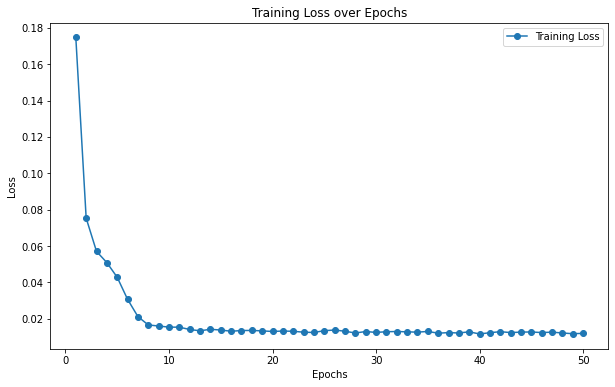

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

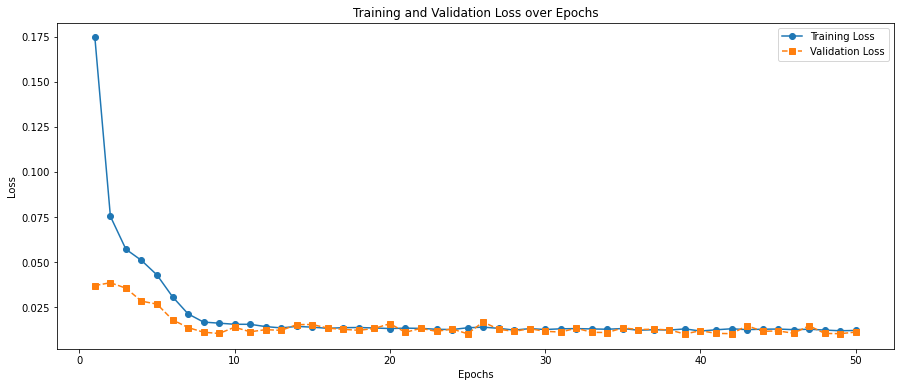

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 17ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10102510797445151
MAE : 0.08361454719612559


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,4045.196289,54595.378
1,158571.734375,242829.930
2,311106.437500,406860.687
3,440755.156250,605897.837
4,540203.312500,654073.790
5,595292.562500,701143.910
6,587069.812500,657891.340
7,475160.437500,432215.421
8,284943.437500,201834.787
9,87295.968750,55041.511


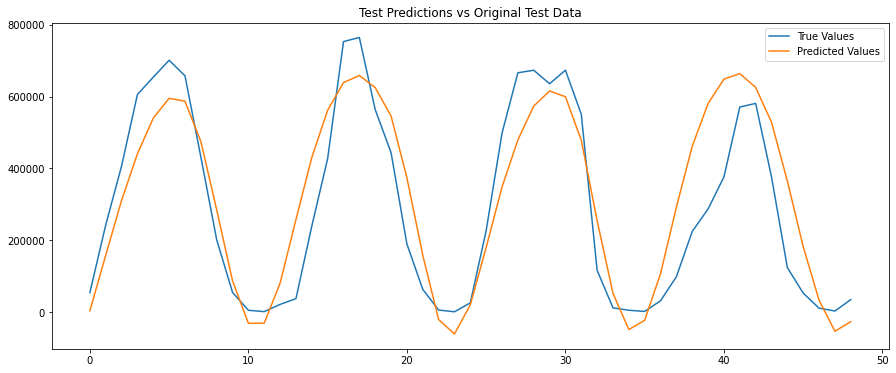

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 27ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

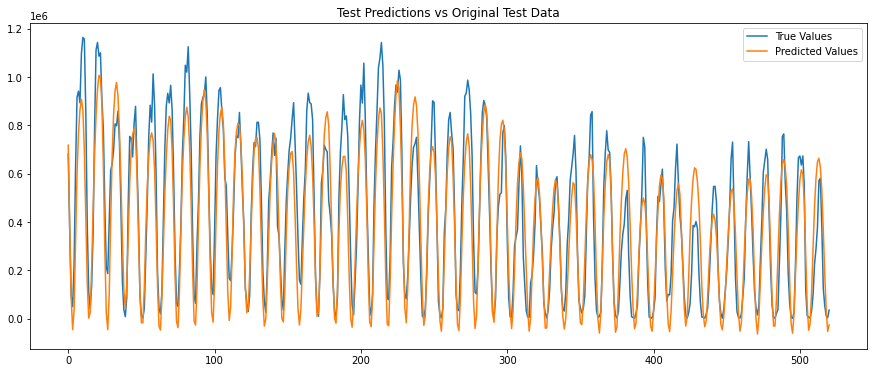

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()